### [HOME](http://ifni.co)  | [source code](https://github.com/vsraptor/threensitions)

-----

# Three-nsitions
----

What follows is explanation and implementation of an idea I have of a method of handling Time Series, at least slightly different than traditional methods.

*I'm approaching the problem from a programmer rather than mathematical point of view. It is astonishing how little there is out there for programmers. Mostly math papers. Which is good for reference, but for learning the ideas seems to me very contra productive. So I'm tailoring this towards programmers and mere mortals :).*

In addition with this article I'm trying to provide you with the process of creating a meta-model i.e.  **Assumptions => Building model => Assessment**, rinse and repeat. 

So here goes ....

-----

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import sys
sys.path.append('../lib')
from threensition_ts import *
from threensition_3d_ts import *

#those DataSets are not available in the repo, it is external library and will take me some time to integrate it
# ... for now what you need is to load your data-set in 1D numpy array by some other means. Sorry..
from data_sources.data_sets import DataSet
ny_taxi = DataSet(fname='../data/nyc_taxi.csv', field='passenger_count')
hot_gym = DataSet(fname='../data/rec-center-hourly.csv', field='kw_energy_consumption')

# Time series and chains
----

What is **three-nsition** ? Glad you asked :)

In two words it is a way to do prediction of Time Series.
Normally you would use Markov chains or Autoregressive models to do that.
Three-nstion is sort of Markov chain with a twist.

But first before we go into the details we need to understand what is Markov chain in the first place. 


## Markov chain order-1

Graphically the model looks something like this :

![order 1](img/jupyter/order1.png)

Where every time step is represented by separate variable **x** which can take one of many possible values often called states **S={s1,s2,s3, .....,s_m}**.
The arrows describe dependencies between those variables. 

If we forget the arrows for a moment, what would the best possible model be using those variables ? Well, it would be best to know the dependencies between all variables, this way we can build the perfect model.
But that is not practical to do. 

Let's think about it for a moment if we pick the simplest case where the variables can take only two values/states i.e. **{0,1}**. The number of possible dependencies will be **(2^n - 1)**. Above 20 time steps things start to get really, really rough from computational perspective.

*So what is the solution ?*

Easy, find a way to represent the sequence by using less dependency between variables.
The easiest and most natural choice would be to use the so called Markov chain of order-1 (the one we already saw in the image above) i.e. make a model where every variable depend only on the previous time-step in the sequence.

How would a model of Markov chain order-1 look like :


|   |  s1 |  s2 | s3  |
|---|-----|-----|-----|
|s1 |  2  |  0  |  3  |
|s2 |  0  |  1  |  5  |
|s3 |  1  |  0  |  0  |


Here is a model for a time series that have 3 possible states **S={s1,s2,s3}**. The numbers inside the table are simply counters of how many times event **Xt+1** happened after event **X_t**. F.e. the number 5 on *row 2*, *col 3*, tells us that we had *5 transitions* so far i.e. **2 =5=> 3**, also the models tells us that when we see **state:2** we can assume the the best next state (i.e. prediction) will be **state:3**.

*(Using counters is easier to visualize, but they are synonymous to probabilities. In the current case we can just divide every cell by the sum of all counters and we will have probabilities. Probabilities also have the drawback that over time become very very small, causing floating point underflow. Especially when the table become sparse. The solution is to start using log-of-probabilities. On the other hand probabilities are very good for reasoning about models)*

What we did seems good, the problem though is that this model is very simplistic, we can see that once in a while we have to predict **state:2** after **state:2**, **2 =1=> 2**. A thing we can do to resolve this problem is to randomly generate state 1,2 or 3 with a higher tendency (probability) of predicting the state with the higher counter.

## Markov chain order-n

But probably better approach would be if we use more complex model. F.e. we can use Markov chain model of **order-2**.
What this mean is that now every variable will depend on the previous two states, rather than on just one.

![order 2](img/jupyter/order2.png)

To make this work instead of using 2D table as a model we would have to use 3D cube to store the transition counters/probabilities ... for every increase of the  markov-order we have to add one more dimension. We see that this puts us on the same path of information explosion as before.

So here is a conundrum how can we *"have a cake and eat it too"* i.e. have complex enough model capturing as many dependencies as possible without this combinatorial explosion of information we need to store.

*One abstract way to think about is to imagine it as a sort of "compression"*

## Hidden Markov model

Another more complex model is the so called **Hidden Markov model (HMM)**. The idea here is to limit the dependencies but capture the information with a hidden variable (which does not necessarily use the same states as the original variables).

![hmm](img/jupyter/hmm.png)

(**h** are the hidden states)

Here the next time step depends on only one hidden variable, but this time instead of building N-dimensional "table", we depend on dynamic process that calculates the hidden variable at every time step.
The model can be represented by 2 transitional 2D arrays.
From the diagram we can see that :

> $$ p(x_t) = p(x_t|h_t) * p(h_t|h_{t-1})$$

The assumption here is that the second probability was calculated before hand, that is why I said it is a process. The two 2D arrays are called transition and emission tables (distributions).

HMM are not very applicable to time series, but more to tasks like the following : 

Given a sequence X and trained HMM model tell me how probable the sequence X is to be generated by this model ? 

So to generate a prediction you need to generate all possible context+future_state sequences, then pick the most probable one. 
Also because it is not one simple table the learning process is much more involved.

## HTM

Yet another approach is what Numenta does with their **Temporal memory**. 

Here the Memory stores markov order-1 transitions, but because the states themselves are firstly dynamically spawned (not preset in advance, so you can have practically unlimited number of states) and secondly encoded as Sparse Distributed Representation what happens is that order-1 transition on the fly get connected in higher-order chains, depending on the incoming time series data.
They are in a sense data dependent Variable-Order markov chains.

The model is not 2D real numbers table, but sort of virtual ~2D bit array~, where each state is represented by multiple indexes, rather than single index like in the markov models. I'm simplifying abit, so that I can make the comparison.

You can read in more detail about it in my test TM implementation [Bare bones HTM](http://ifni.co/bbHTM.html) or at [Numenta site](http://numenta.org).

## Autoregressive models
----

 ..... TODO .....
 
 -----

## Three-nsitions
----

> ** Give me the place to stand, and I shall move the earth. ~Archimedes**

Now that we explored the landscape lets get back to our original question : What the hell is threensition ?

It is sort of Higher order Markov chain where we have only 3 Super states : **PAST => PRESENT => FUTURE**.

![ppf](img/jupyter/ppf.png)

 1. The **PAST (p)** super-state is a placeholder for a multiple states that happened in the past just before the present : **p1, p2, p3, ..., pl** where *L* is the number of past states we will consider for the calculation. I normally call it *context* in the code.
 2. The **PRESENT|NOW (n)** super-state is the fulcrum of the system. We use it as mechanism to lower the amount of information we need to store for the model.
 3. The **FUTURE (f)** super-state is the prediction and dependent only on state **n**.

![threensition](img/jupyter/3nsition.png)

As it can be seen by the graphic model all predictions happen trough the **PRESENT|NOW** state.
If you stretch it visually it may look like NN neuron, but functionally it will be more like ensamble (lateral-row not column) of HTM-neurons, where the Present state is the **column-selector** (i.e which neuron is activated) and the Past is the pattern that comes at the **distal-dendrites**. I hope those familiar with HTM can visualize it. 

I should mention one additional property of Markov models before we continue : stationarity. 
A model is stationary if the dependent-variables are not themselves dependent on time.

  > stationary     : $$p(x_{t+1}=s_2 | x_t=s_1) = function(s_1,s_2)$$
  > non-stationary : $$p(x_{t+1}=s_2 | x_t=s_1) = function(s_1,s_2,time)$$


I have so far two different implementations of this scheme and I'm thinking of a third one.
We will start with the easier one first, so that you can understand the idea better.

### Buffer model
----

![sin](img/jupyter/sin2.png)

The first algorithm is based on holding in a buffer large enough data points of the time series.
It goes something like this (keep looking at the diagram):

  1. **Prediction step** :
    - look-back for states that match the PRESENT (**n**) state , lets call them **mn**
    - for every match **mn** compare the PAST **p[1], p[2] .. p[l]** states with the past matched states,
      **mp[1], mp[2], ... mp[l]**, pick one or many future states : **future_state = mf** 
       - for every matching pair  **p == mp** increase the corresponding counter of **score[future_state]**
    - after reaching the beginning of the buffer pick the **future_state** with maximum score, this is the prediction      
  2. **Learning step** :
    - Update the buffer with the current state (roll/shift the buffer to the left)

It is essentially look-back search with counting.
For this sinusoid the value of **mf** will always be the same, but if the signal is irregular different future values/states will get different scores ergo different predictions.

The Buffer model is of the non-stationary kind i.e. p[x] == mp[x] counts, but p[x] == mp[y] does not.
Position relative to the PRESENT state in the comparison matter.

One very important thing about those models I have not mentioned yet is **smoothing**. 

As you will see in the next model too, the time series values normally are real numbers, but we know that we have limited number of states to represent them.

There are three ways to solve this problem.

1. Use fuzzy matching, which complicates the algorithm.
2. Second option is to use representation which naturally handless fuzziness, example of this is Sparse Distributed Representation (SDR), which is the project I'm still thinking about and probably will be the final best model, I hope !! if I can invent it ;), anyway this has always been my target from the beginning (I just happened to invent threensitions as I was thinking about it ).
3. And the third and easiest option is to **smooth** the signal which is what we are doing here.

There are also different ways to do smoothing in this **Buffer model** we will use resolution method f.e. resolution=5,  mean that before processing every data entry will be encoded in such a way that the values can take only specific values in this case 2.5, 7.5, 12.5, 17.5... this guarantees us that we can match them effortlessly. 

----

**Pros and cons :**

1. The benefit of this model are :
  - Easy to understand and implement
  - Can do prediction multiple steps ahead, which is not true for other methods
  - Fast, because we first search for match for **n** state and then do the expensive operation of comparing **p == mp**
2. Drawbacks are :
  - Not very good to reason about.
  - In essense copy&paste, you can see this if you predict multiple steps ahead.
  
Let's now experiment with the code. 
Quickly let explore the data properties.

In [2]:
print "min:", ny_taxi.data.min()
print "max:", ny_taxi.data.max()
print "size:", ny_taxi.data.size

min: 16
max: 39205
size: 17520


1. Ok.. the procedure is very easy we have to create TTS (threensition time series) object. The meaning of the parameters are :
  - **buffer_len** : what part of the signal we would use to "gather" statistics (look back length).
  - **ctx_len** : how much of the Past data we should consider matching. It is not always good to use big number. It depends on the time series.
  - **smooth** : this almost definitely has to be true, otherwise this model would work only on clean signals.
  - **resolution** : defines the steps between smoothed state values.
  
2. Now we have to train the model. Simply passing the data (1D numpy array) to batch_train() will be enough.  

3. Print the statistics to see how well the model behaves. If you want to see what stats functions do check the source of stats class. 
 - You can provide skip=X to skip the first X data point when calculating the stats. You may wanna do that because it takes a while for the model to settle.
 - original=True instruct the object to calculate statistics against the original signal, not against the smoothed one.

4. Finally you  can plot the  graph. The smoothed signal is blue color, the predicted is in green.
  - original=True means that it will draw in yellow the original signal.

> BTW, both model can run in batch and online mode w/o problem, you just have to call different methods : batch_train() vs train(). If you decide to use the models for online mode you have to probably remove all statistics related arrays, so that the object don't eat all the memory over time.



In [3]:
t = TTS(buffer_len=1000, ctx_len=60, smooth=True, resolution=300)
t.batch_train(ny_taxi.data[:1000])
t.stats(skip=100)

==== MODEL stats ==============
mape:  0.167461405158
mae :  2461.43174251
rmse:  4797.93674441
r2:  0.473038553909
nll:  4.20139469566


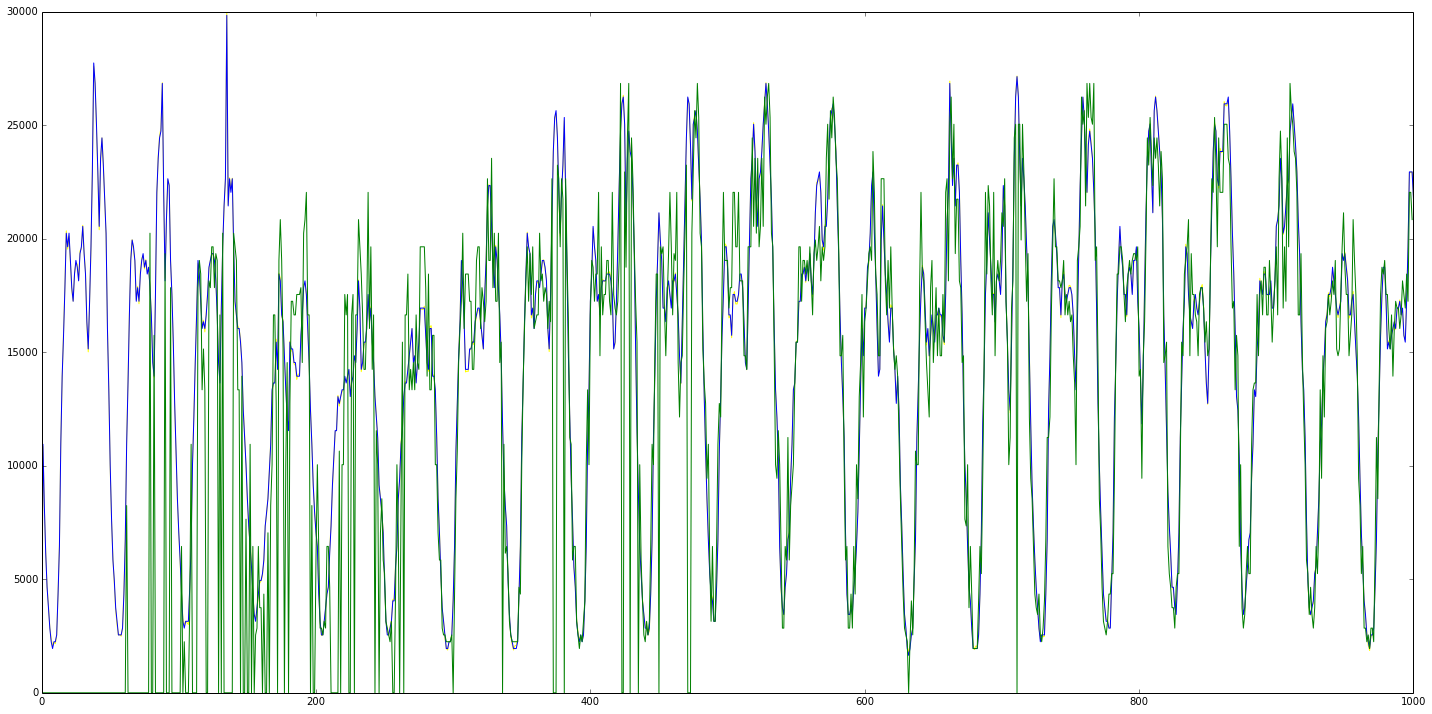

In [13]:
t.plot(original=True)

In [5]:
t.stats(skip=500, original=True)

==== MODEL stats ==============
mape:  0.0941093757526
mae :  1470.28542914
rmse:  2345.4659973
r2:  0.874378479485
nll:  0.389619223192


----
### Sparse/Cube counter model
----

The second implementation is more probabilistic, later I will try to provide mathematical description.

If you remember for Markov chain of order-1 we have 2 variables **PARENT => CHILD** so we used a 2D transition table as a model.
As you may suspect for 3 variables **PAST => PRESENT => FUTURE**, we would need 3D cube.

![cube](img/jupyter/cube.png)

In the visualization above the **y-axis(rows)** represent PAST states, **x-axis(cols)** represent PRESENT states, **z-axis(depth)** represents FUTURE states.

All variables accept the same number of states ... f.e. 100x100x100 cube allows us to store counters for 100 states/values. (*I was worried the memory consumption will prohibit using this specific implementation, but was pleasantly surprised to find that 200 states are more than enough in my test cases.*)

The algorithm is very easy :

1. Prediction : What we have as input is the context (i.e. past) and the present state
  - **p** states (not a single state) select the rows **y** coordinates.
  - **n** selects the column **x** coordinate (this is the slice in the picture)
  - This operation picks stripes of the 2D slice, which we sum vertically along Y-axis.
  - The result is array of scores, the index of the max score is the prediction.
  - Here is how it looks in python :
      **future = map[past,present,:].sum(axis=0).argmax()**
2. Learning : for every time step
  - increase the cross section given by the coordinates  : **map[ past, now, future ] += 1**
   
   Which means this : **map[ [p1,p2,p3..], now, future ]**
    
----  
  
**Pros :**

1. Easy to implement
2. The cube normally is very sparse, which means there is possibility for memory optimization. F.e. using tree instead of 3D array. (BTW don't try to use python based dict-tree, 2% sparse cube when converted required just half the memory size. If the cube sparsity grows abit it it will probably become bigger than 3D cube. Plus tree access will be slower. C++ based tree class may be better, because you can control the memory structure explicitly.)
3. There are some tricks that we can use to overcome the limit on the number of possible states by using SOM or on-the-fly averaging (mimicing HTM Spatial pooler).
4. Fast
5. No need to use probabilities, counters do fine.
6. Did I say it is fast ~20000+ data points in a sec on my slow laptop

**Cons :**

1. More than couple of hundred states is unfeasible, because of memory consumption. 
2. Can predict only one n-step forward, if 3D.


Let's check the properties of the signal. This time we will need the information.

In [6]:
print "min:", ny_taxi.data.min()
print "max:", ny_taxi.data.max()
print "size:", ny_taxi.data.size

min: 16
max: 39205
size: 17520


Again like the previous model we have **ctx_len**, but this time we have to provide *number of states* , *minimum* and *maximum* value. The reason for this is because the **smoothing** in this model is based on the range of the values. The resolution step is basically **resolution = range/nstates**. If you look below in the stats you can see the resolution for this range is 150.

What is different than the previous model is also **"zero_freqs=True"**, we cheat somewhat to solve the so called *zero-frequency problem* (_for which you can read at the end of this article_).

Whenever we get as prediction 0 or max state we substitute for it with the previous time series value (you can easily change the code to use the last predicted instead).
If you look at the graph of the *Buffer model*, those are the abrupt drops to zero in the graph. To give you some idea how often this happen if you provide **nope=True** when you plot the signal those cases will show as a red dots.

I was surprised that more **nstates** and/or **ctx_len** is not always a good idea, it seems that my tests behave well with around 200 states. Probably some sort of over/under fitting. Because the cube is very sparse increasing the number of states may be makes it so sparse that there is not enough statistics to distinguish the winning state vs noise.

*Also in this tutorial I limit the data points that are trained for visual purposes, so you can see clearer graph.*

==== MODEL stats ==============
mape: 9.024% 
mae : 1328.004
rmse: 1851.882
r2: 92.170%
nll:  0.995
resolution: 150.0
======== TDSM =================
MLL: 23
MLL ix: (past, present, future) (199, 124, 120)
sparsity: 0.46%
mem: 15.26 MB


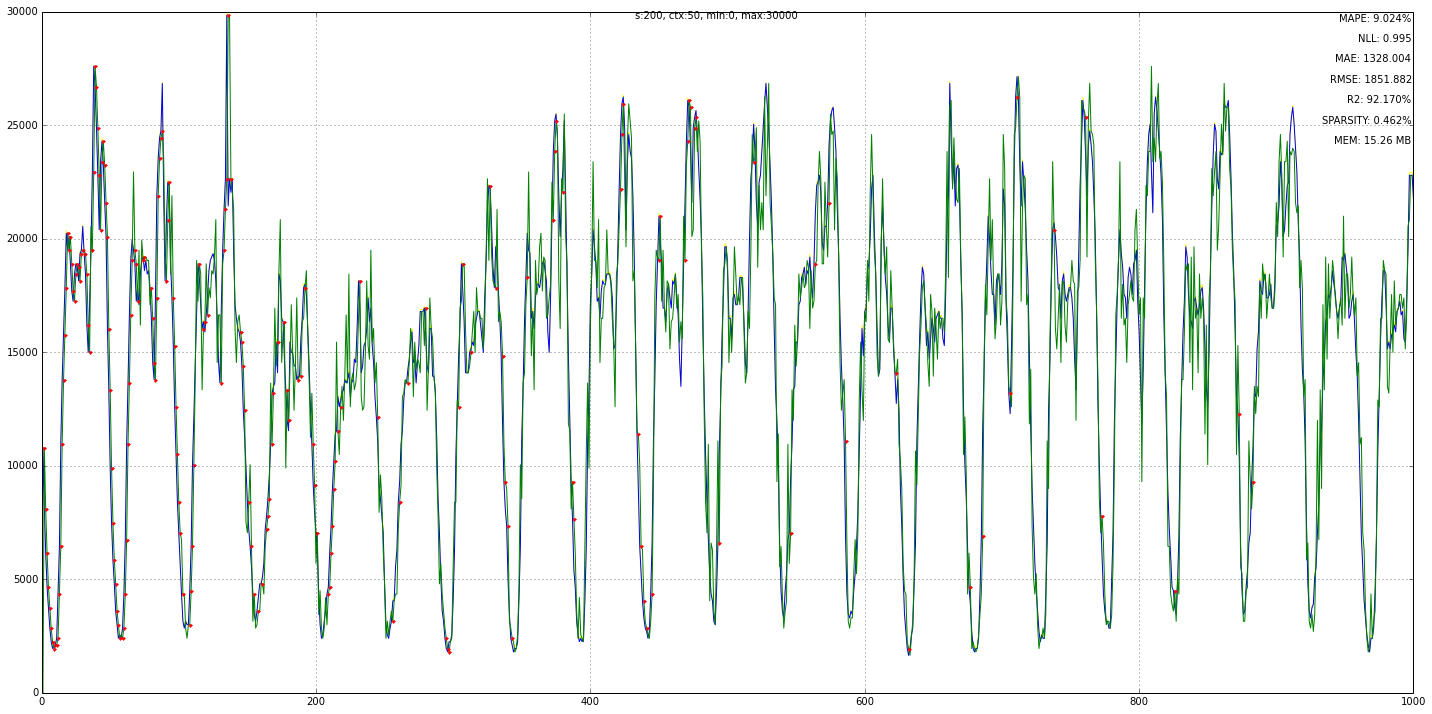

In [7]:
t3 = TDTTS(nstates=200, ctx_len=50, vmin=0, vmax=30000, zero_freqs=True)
t3.batch_train(ny_taxi.data[:1000])
t3.plot(original=True, nope=True)

Let's try the hot-gym data set ... we plot after the 500th step, just for test.

In [8]:
print "min:", hot_gym.data.min()
print "max:", hot_gym.data.max()
print "size:", hot_gym.data.size

min: 88
max: 953
size: 4390


==== MODEL stats ==============
mape: 13.868% 
mae : 45.146
rmse: 77.412
r2: 76.539%
nll:  0.503
resolution: 5.66666666667
======== TDSM =================
MLL: 2482
MLL ix: (past, present, future) (6, 6, 6)
sparsity: 0.89%
mem: 6.44 MB


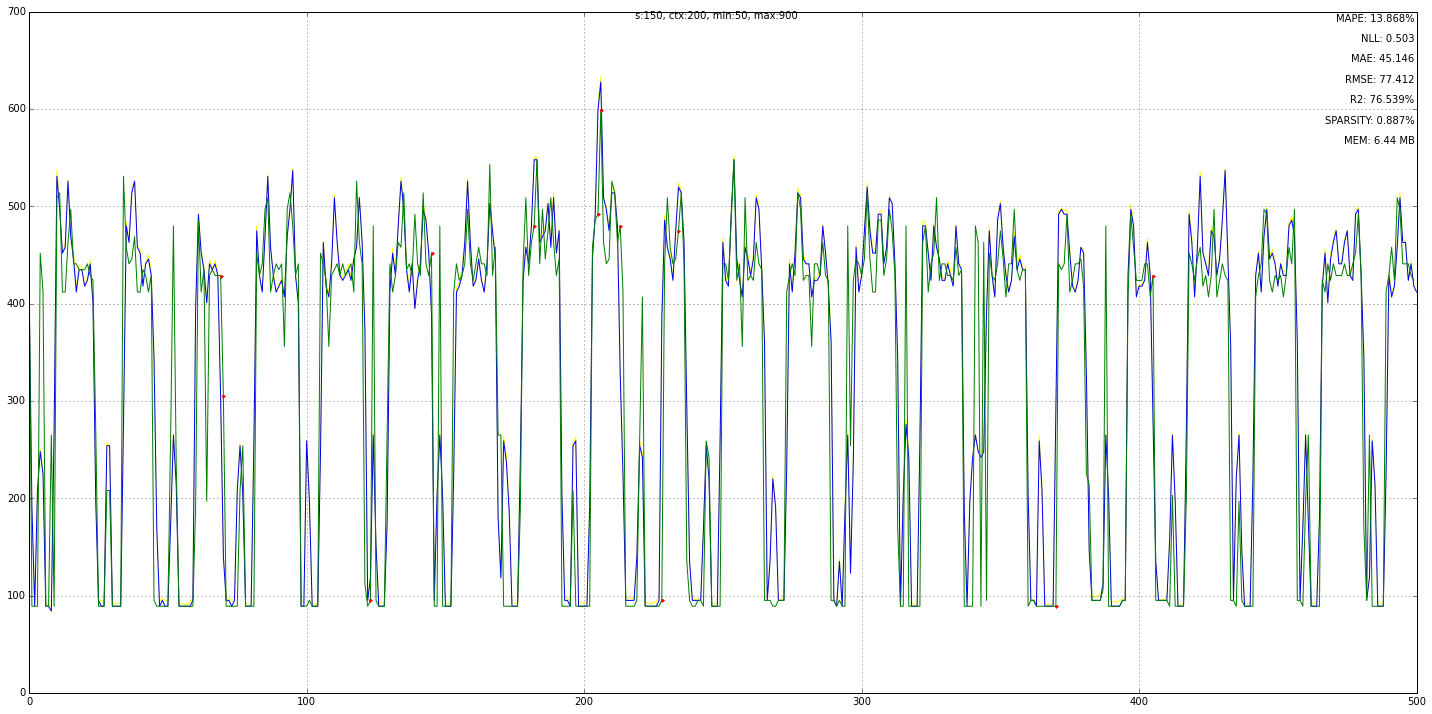

In [12]:
t4 = TDTTS(nstates=150, ctx_len=200, vmin=50, vmax=900, zero_freqs=True)
t4.batch_train(hot_gym.data[:1000])
t4.plot(skip=500, original=True, nope=True)

### Self Organized Maps (SOM)
----

As I already mentioned because of the memory usage we can not use too many states.
So we have to find a way to utilize better the available ones. (Btw. less states is also good from another perspective it takes care of the noise if we have enough states for the general underlying signal).

We did this with **resolution smoothing** for the Buffer model and **range smoothing** for the 3D cube model, but there is one more improvement we can do.

We can have range smoothing, but instead hard coded values we can allow the numbers to "float" within their range depending on the incoming data. F.e. let say that the range forces us to use state-1 with value 5 and state-2 with value 15, but very often in the data we have 7 and 8, rather than 5, wouldn't be better if we can change state-1 to to use value 7.5 instead.

That is what we can do with SOM i.e. as the data comes it nudges the state-values towards better resembling the incoming data. You can read more about SOM in my test implementation of [Spatial-mapper](http://ifni.co/spatial_mapper.html).

Did I say Spatial mapper :). Functionally SOM is a Spatial Mapper. The difference is that this one is real-numbers based  and the other one is SDR based.

*I'm currently still testing my real-numbers SOM implementation as a standalone piece, but will soon fold it in the 3D cube model.*


### Probabilistic model
----



I'm new with this mathematization of computer algorithms and probabilities, so give me some slack and definitely ping me if you see some mistake. So here goes ...

Normally a probabilistic model requires the definition of the so called **joint distribution**. If you have 2 variables, let say x and y you can imagine it as a table where we know the probability for every combinations.

f.e. as **counters** :

| y\x  |  s1 |  s2 | s3  | 
|---|-----|-----|-----|
|s1 |  2  |  5  |  3  |
|s2 |  0  |  1  |  9  |
|s3 |  10  |  0  |  0  |

So given this table we know that :

> $$p(x=s_3,y=s_2) = 9/30 = 30\%$$

the sum of all elements is 30.

and the same table as probabilities **p(x,y)** :

| y\x  |  s1 |  s2 | s3  | 
|---|-----|-----|-----|
|s1 |  0.06  |  0.17  |  0.10  |
|s2 |  0.00  |  0.03  |  0.30  |
|s3 |  0.33  |  0.00  |  0.00  |


from this we can calculate any other probability we may need f.e. :

> $$p(y=s_2) = 0.00 + 0.03+0.30 = 0.33 => 33\%$$
> $$p(y=s_1|x=s_2) = 0.17/(0.17+0.03+0.00) = 0.85 => 85\%$$
> $$p(y=s_1|x) = [0.15, 0.85, 0.25]$$

and so on .... you get the point.
So if we know the joint distribution it means we know the content of every cell in the table.

The problem is most often it is impossible to have the full joint distribution either because we don't have enough data to collect the statistics or because it is computationally very expensive, especially if we have more than two variables.
For every new variable we have to add one more dimension.

What we try to do with the graph models is to state dependencies explicitly which in turn allows us to disregard the rest and lower the complexity of the model.
F.e. the threensition model is defacto L+2 variables, but with the Past=>Present=>Future simplification we were able to bring it down to 3 variables, on top of that on the tests I've done so far only 2-5% of the cube contains counters the rest are zeros. 

Let's see again the threensition model.

![ppf](img/jupyter/ppf.png)

We would use the canonical formulas in probabilities :

> Marginalization: $$p(x) = \sum_y p(x,y)$$
> Product rule : $$p(x,y) = p(x|y)p(y) = p(y|x)p(x)$$
> Three variables : $$p(x,y,z) = p(x|y,z)p(y,z) = p(x|y,z)p(y|z)p(z) $$

We said we have 3 variables :

> Past(P), Present(N), Future (F) 

Also the Past is a abstraction of multiple variables **p1,p2,p3, ..., pl**, which implies that our **joint distribution** look like this **p(p1,p2,p2,...,pl,N,F)**, which will indicate we would need L+2 dimensional cube, but ... we substitute all *p's* with single "instantaneous" variable P.

By this I make the model assumption that all *p's* select single N state i.e. **p(N|P) = (N|p1,p2, ...,pl)**.
It is important to note that I made an **assumption**. This was not obvious to me at the beginning when I was exploring machine learning models i.e. we make trade-off between complexity of the meta-model and the process we are trying to model. Then we test and if we don't get satisfactory results we either scrap the meta-model or make different assumptions and start again. By meta models I mean Markov chains, HMM, AR, SVM, Regression, NN ...

The assumption I made here seem to work that is why I stuck with it.

Now at last our joint distribution p(P,N,F) will be modeled by 3D transition cube.

Let see if it will work mathematically. 

> **What is our final goal ? Predict a Future state.**

Which in this case is the marginal.

According to the PNF-graph it is :

> $$p(F) = p(F|N)* p(N|P) = p(F|N) * p(N|p1,p2,p3, ... pl)$$

Where **L** is the number of context states.

Let see if that is true, by applying Marginal rule and then the production rule, if we have the joint p(F,N,P) and we want to calculate the marginal :

> $$p(F) = \sum_{N,P} p(F,N,P) = \sum_{N,P} p(F|N,P) p(N|P) p(P)$$

But we made the assumption that F depends only on N and is independent of P, so we can remove it from p(F|N,~~P~~).
> $$p(F) = \sum_{N,P} p(F|N) p(N|P) p(P)$$


huh... we got one additional item i.e. **p(P)**, why is that ? 
If we take our assumptions into account then :

> p(P=s_n) <=> function(state_n, ctx_state) = ctx_state == 1 and state_n == ctx_state ? 1 : 0

i.e. if context state and the state we are checking are the same and the context state is 1, then p(P=s_n) = 1 otherwise it is zero.

Let's try specific example with three states  **S={s1,s2,s3}**, and let say this is the **context={s1=1, s2=0, s3=1}** :
> $$p(F=s_1) = \sum_{n=1}^{L} p(F=s_1|N=s_n) p(N=s_n|P=s_n) p(P=s_n) $$
> $$ = p(F=s_1|N=s_1) p(N=s_1|P=s_1) p(P=s_1) + p(F=s_1|N=s_2) p(N=s_2|P=s_2) p(P=s_2) + p(F=s_1|N=s_3) p(N=s_3|P=s_3) p(P=s_3) $$
> $$ = p(F=s_1|N=s_1) * p(N=s_1|P=s_1) * 1 + p(F=s_1|N=s_3) * p(N=s_3|P=s_3) * 1 $$

but **p(P=s2)** is zero, so this means we can remove the sub expression that uses state s2.
Aaaa, so this term is a sort filter that tells us which subexpressions to exclude from the calculation. Make sense ?

Remember when I was explaining the 3D cube I mentioned we use only "stripes" from the PRESENT-sheet, not the whole sheet.

----

So lets state again our final Probability model is :

> $$p(F) = argmax \sum_{n=1}^{L} p(F|N) p(N|P) p(P)$$

Here *argmax* is the requirement to pick the Future state with the best score.



## Musings
----

So far this and similar models are good for range-bound repeatable signals where the collected statistics get more and more relevant, and not so good for trending signals. What do I mean by that ?

#### Permutation Transformation problem

In the literature subset of what I dubbed **Permutation Transformation (PT)** is the so called **"zero-frequency"** problem. I think mine definition is more abstract and explains possible avenue of attack as I will explain in a minute.


So the **zero-frequency** problem as the names implies is what do we do in cases where we did not collect statistics yet i.e. new state show up for the first time (HTM bursing mode, anyone :)). 

Good example of this is a trending signal where new states/values not seen earlier pop-up all the time.
I'm still exploring how this problem is handled in the literature. It is most often discussed in the Compression papers. *(if you've seen the red-dots on the graph I mentioned earlier, those are exactly zero freq. cases)*


Why did I call this **Permutation Transformation** problem.
As we are processing a signal we are assuming we have no other external information so the only information we have is the signal itself. By collecting statistics we can predict with any certainty only states we already encountered.
But if you stop and think for a moment we can transform the same signal in infinite ways f.e. we can scale it, skew it, FFT-it, find linear dependencies (that's why AR can handle trending signals) and generate brand new states/values which are still only dependent on the signal itself.
So if we can create a model that represent most probable **transformations** of the data not only the most probable **known-transitions** we can in theory predict most probable new states.

#### Far-ahead prediction

Threensition and most other models as we saw predict one n-step ahead, but with time series what we really want is to predict multiple steps ahead, as the Buffer model can do, but better. Like AR-models but better, the auto-correlation and trend extraction should happen automatically by Permutation-Transformation or some such.

My current thinking on this is that this should be solved by external-forces.
For example Reinforcement learning where Threensition+Permutation-Transformation is the model part of the algorithm and RL guides the most probable prediction path. The problem here as far as I understand it is that there is no obvious way to figure out a **reward function**. RL can do w/o other stuff, but the assumption is you have to have a reward function. 

If you are familiar with Trending analysis for Stock trading ... stuff like shape, trend-lines and so on can be used as **REWARDS** in a RL algorithm.

Then you chain together many of them in hierarchy and voila :)

This also seems to tie well with HTM theory, where the TM is the model and the feedback mechanisms are sort of RL on steroids.

*Hope you liked this expose !*